### Installing dependencies

In [ ]:
!pip install qwen-vl-utils

In [ ]:
!pip install -q ultralytics transformers accelerate einops safetensors

### Importing libraries

In [ ]:
# Import required modules
import cv2
import torch
import numpy as np
import textwrap
from PIL import Image as PILImage
import matplotlib.pyplot as plt
from ultralytics import YOLO
from transformers import (
    Qwen2_5_VLForConditionalGeneration,
    AutoProcessor,
)
from qwen_vl_utils import process_vision_info
import IPython.display as ipd

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


### Setting up Qwen 2.5 with 3B Parameters

In [ ]:
# Device setup
device = "cuda" if torch.cuda.is_available() else "cpu"
model_id = "Qwen/Qwen2.5-VL-3B-Instruct"

# Load Qwen2.5-VL model and processor
print("⏳ Loading Qwen2.5-VL...")
model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    model_id,
    torch_dtype="auto",
    device_map="auto"
)

### Load YOLO plate detection model and Qwen 2.5 model

In [ ]:
processor = AutoProcessor.from_pretrained(model_id)
print(f"✅ Qwen2.5-VL loaded on: {model.device}")

# Load YOLOv8 license plate model
plate_model = YOLO('plate.pt')  # Make sure this file is in your current working directory

### Prompting Qwen 2.5 model

In [ ]:
def qwen_ocr_from_plate_crop(plate_crop_bgr):
    # Convert OpenCV BGR to PIL RGB
    plate_pil = PILImage.fromarray(cv2.cvtColor(plate_crop_bgr, cv2.COLOR_BGR2RGB))

    msgs = [
        {"role": "system", "content": "You are a indonesian license plate reader"},
        {
            "role": "user",
            "content": [
                {"type": "image", "image": plate_pil},
                {"type": "text", "text": "Only output the license plate number. Do not include extra words. Do not read the date under the plate number."}
            ]
        }
    ]

    text_prompt = processor.apply_chat_template(
        msgs, tokenize=False, add_generation_prompt=True
    )
    image_inputs, video_inputs = process_vision_info(msgs)

    inputs = processor(
        text=[text_prompt],
        images=image_inputs,
        videos=video_inputs,
        padding=True,
        return_tensors="pt"
    ).to(model.device)

    with torch.no_grad():
        generated_ids = model.generate(**inputs, max_new_tokens=64)

    caption = processor.batch_decode(
        generated_ids[:, inputs.input_ids.shape[-1]:],
        skip_special_tokens=True
    )[0]

    return caption.strip()

### Load Input example

In [ ]:
# Load input image
image_path = 'avanza.jpg'
img = cv2.imread(image_path)
if img is None:
    raise FileNotFoundError(f"Image not found: {image_path}")
annotated = img.copy()

### Detecting plates by YOLO and OCR by Qwen 2.5

In [ ]:
# Detect plates
results = plate_model(img)[0]

for i, box in enumerate(results.boxes):
    conf = float(box.conf[0])
    x1, y1, x2, y2 = map(int, box.xyxy[0])
    label = f"Plate {conf:.2f}"

    # Draw "Plate" bounding box
    cv2.rectangle(annotated, (x1, y1), (x2, y2), (0, 255, 255), 2)

    # Crop and OCR
    plate_crop = img[y1:y2, x1:x2]
    if plate_crop.shape[0] > 0 and plate_crop.shape[1] > 0:
        ocr_text = qwen_ocr_from_plate_crop(plate_crop)
        print(f"OCR Plate {i+1}: {ocr_text}")

        # Calculate text sizes
        (ocr_w, ocr_h), _ = cv2.getTextSize(ocr_text, cv2.FONT_HERSHEY_SIMPLEX, 0.7, 2)
        (tag_w, tag_h), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)

        # Draw OCR above plate label
        ocr_y1 = y1 - tag_h - ocr_h - 24
        ocr_y2 = y1 - tag_h - 10
        cv2.rectangle(annotated, (x1, ocr_y1), (x1 + ocr_w + 6, ocr_y2), (0, 0, 0), -1)
        cv2.putText(annotated, ocr_text, (x1 + 3, ocr_y2 - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

        # Draw Plate label below OCR
        tag_y1 = y1 - tag_h - 10
        tag_y2 = y1
        cv2.rectangle(annotated, (x1, tag_y1), (x1 + tag_w + 6, tag_y2), (0, 255, 255), -1)
        cv2.putText(annotated, label, (x1 + 3, tag_y2 - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 2)


0: 160x320 1 number_plate, 18.8ms
Speed: 1.7ms preprocess, 18.8ms inference, 1.9ms postprocess per image at shape (1, 3, 160, 320)
OCR Plate 1: DK 1579 FE


### Display the result


 Saved result: output_plate_qwen.jpg


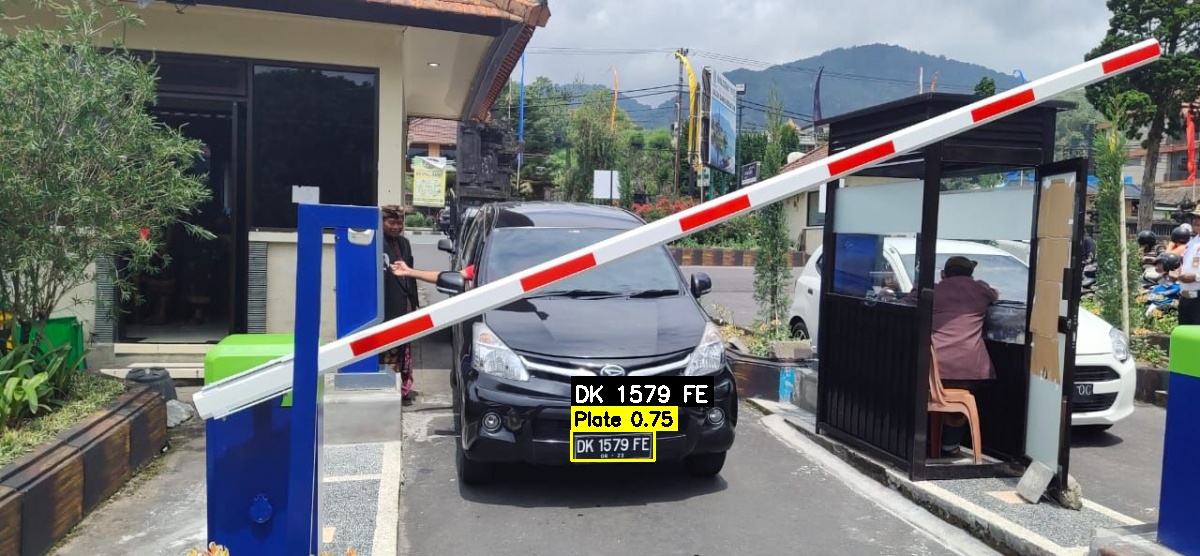

In [ ]:
# Save and display result
output_path = 'output_plate_qwen.jpg'
cv2.imwrite(output_path, annotated)
print(f"\n Saved result: {output_path}")
ipd.Image(output_path)